## Advanced Feature Engineering for Time‑Series Data

## Objective:

Explore and apply intermediate‑to‑advanced feature‑engineering techniques that are **specific to temporal data**. The following steps were performed:

* Reshape wide‑table energy data into a tidy, long format suitable for time‑series analysis.
* Construct fundamental temporal features including **year‑over‑year (YoY) difference** and **YoY percentage change**.
* Understand and explain the purpose of lag features and rolling‑window statistics—and create them on demand.
* Perform chronological train/test splits and discuss why random shuffling is inappropriate for time‑dependent data.
* Evaluate a baseline regression model and interpret mean‑squared‑error (MSE) and $R^2$ scores in the context of energy‑consumption forecasting.

## Scenario:

You are part of an energy analytics team at **Nexergy Metrics**.  Management wants a lightweight forecasting tool that can flag countries experiencing rapid change in primary‑energy consumption.  You have been given a historical dataset that lists annual energy‑consumption figures for every country from 1965 to 2023—one column per calendar year.  Your job is to reshape the data, create time‑series features (YoY change & YoY % change), split chronologically at **2010** for modelling, and build a quick linear‑regression baseline.  You will extend the feature set (e.g., rolling means, additional lags) and experiment with alternative split years to see how performance changes.

## Dataset Information

* **Name**: *World\_Energy\_By\_Country\_And\_Region\_1965\_to\_2023.csv* 
* **Source / Author**: [The Energy Institute](https://www.energyinst.org/statistical-review/resources-and-data-downloads) 
* **Description**: Annual primary‑energy‑consumption values (in exajoules) for every sovereign country plus several supra‑national groups, covering **1965–2023**. The Energy Institute Statistical Review of World Energy™ analyses data on world energy markets from the prior year. Previously produced by bp, the Review has been providing timely, comprehensive and objective data to the energy community since 1952
* **Format**: CSV (wide).  Columns:
  * `Country` – country or bloc name (string)
  * `1965`, `1966`, …, `2023` – numeric consumption values (one column per year)
* **Size**: \~14 k rows × 60 columns (≈1 MB).
* **License**: Creative Commons Attribution‑ShareAlike (CC‑BY‑SA 4.0).
* **Kaggle Download:** [World Energy Consumption](https://www.kaggle.com/datasets/patricklford/world-energy-consumption)

## Demonstration

### Introduction

Each row represents the energy metric for one country in a given year.  Our goal is to build a simple regression baseline that predicts the next‑year value using only two **year‑over‑year (YoY)** features.

### Business Relevance

* **Why accurate energy forecasting matters :** National grids, independent power producers, and multinational corporations need short‑term demand and supply estimates to plan capacity investments, negotiate purchase agreements, hedge fuel costs, and steer decarbonisation road‑maps.
* **Dual value of simple time‑series features :** Even the most sophisticated forecasting pipelines begin with strong baseline features.  Year‑over‑year (YoY) **difference** captures absolute growth, while YoY **percentage change** captures proportional growth—together they often explain a surprising amount of variance with minimal engineering overhead.
* **Beyond energy forecasting :** The same two‑feature baseline is a quick diagnostic for many high‑frequency, country‑level metrics:

  * **Agricultural yield monitoring :** Gauge annual production swings before deploying complex climate models.
  * **Tourism analytics :** Detect sudden surges or drops in visitor numbers that might impact local economies.
  * **Public‑health surveillance :** Flag abnormal year‑on‑year changes in disease incidence to trigger deeper epidemiological analysis.
  * **Macro‑economic indicators :** Provide a first‑pass forecast for GDP components or trade balances, informing policy discussions while more detailed models run.
* **Goal :** Equip learners with a lean, reproducible workflow that (1) reshapes wide‑format time‑series data, (2) engineers two high‑signal YoY features, and (3) builds a chronological train/test split to yield an interpretable baseline.  This ensures they can quickly benchmark performance before layering on more complex lags, rolling windows, or advanced algorithms.

### Steps Overview

1. **Load the Dataset** (wide format).
2. **Simple Visualization for Basic Data Exploration**.
3. **Reshape** to create a `Year` column.
4. **Convert ********`Year`******** to Numeric** and drop invalid rows.
5. **Convert ********`Value`******** to Numeric** and drop invalid rows.
6. **Basic Exploration & Sorting**.
7. **Create Time‑Series Features — YoY difference & YoY percentage change (only).**
8. **Train/Test Split** chronologically (cut‑off year = 2010).
9. **Train a Simple Linear Regression Model** using the two YoY features.

### Step 1: Load the Dataset
We will inspect shape and columns to confirm that our data is in **wide format**, with one column per year. This helps us plan how to reshape the data for time-series analysis.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

df = pd.read_csv('World_Energy_By_Country_And_Region_1965_to_2023 (1).csv')

print("Data Shape:", df.shape)
print("Columns:", df.columns.tolist())
display(df.head(10))

Data Shape: (111, 60)
Columns: ['Country', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']


,Country,1965,1966,1967,1968,1969,1970,1971,1972,1973,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Canada,5.00,5.32,5.57,5.92,6.28,6.73,6.94,7.47,8.11,...,14.43,14.47,14.34,14.54,14.72,14.64,13.76,13.92,14.30,13.95
2,Mexico,1.06,1.12,1.14,1.24,1.36,1.45,1.53,1.69,1.82,...,8.03,7.94,8.11,8.26,8.15,8.07,7.35,7.83,8.18,8.45
3,US,51.98,54.89,56.80,60.19,63.30,65.54,66.92,70.25,73.22,...,93.59,92.69,92.62,92.97,96.37,95.68,88.64,93.44,95.42,94.28
4,Total North America,58.04,61.33,63.51,67.36,70.95,73.72,75.39,79.41,83.16,...,116.04,115.10,115.07,115.76,119.25,118.40,109.75,115.20,117.90,116.68
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Argentina,1.18,1.22,1.26,1.30,1.34,1.27,1.35,1.37,1.43,...,3.53,3.59,3.57,3.57,3.54,3.34,3.13,3.45,3.71,3.67
7,Brazil,0.99,1.08,1.11,1.27,1.39,1.63,1.82,2.08,2.45,...,12.83,12.66,12.36,12.47,12.51,12.72,12.22,12.85,13.44,13.87
8,Chile,0.26,0.28,0.29,0.28,0.31,0.32,0.35,0.36,0.34,...,1.47,1.49,1.56,1.62,1.69,1.71,1.59,1.72,1.81,1.81
9,Colombia,0.35,0.40,0.42,0.43,0.44,0.48,0.48,0.55,0.53,...,1.84,1.74,1.96,1.98,2.01,2.03,1.85,2.07,2.20,2.26


### Observations / Reflections (Step 1)
- The dataset has a `Country` column and many columns labeled by year (`1965`, `1966`, etc.).
- Next, we will reshape the data so each year becomes a row under `Year`.

### Step 2: Simple Visualization for Basic Data Exploration
Below is a quick visualization using the **second row** of data (which might be Canada). We'll plot how that single country's energy values change across the available year columns.

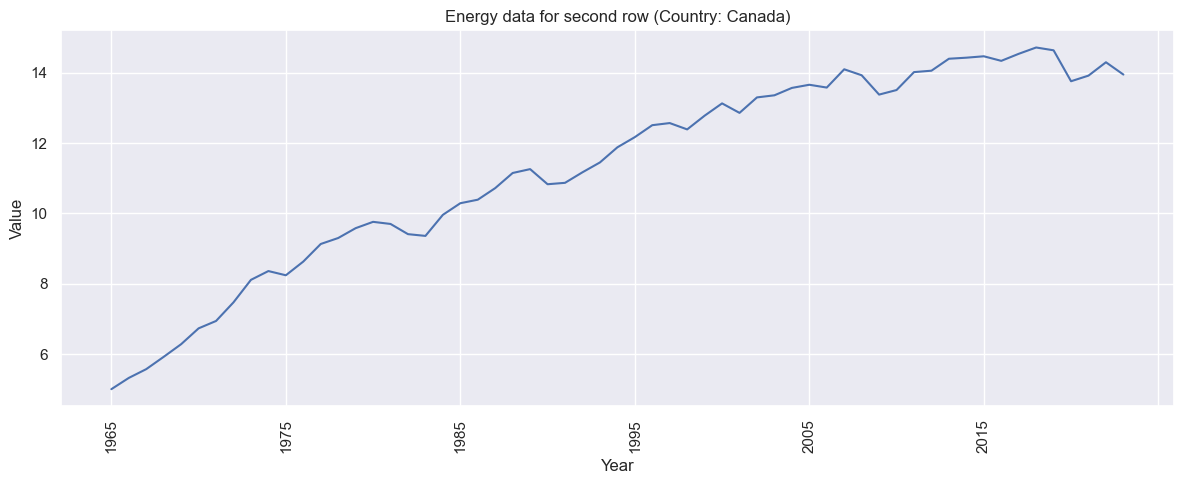

In [10]:
# We'll select the second row (df.iloc[1]), remove 'Country', and convert to numeric.

# Select the second row (e.g., Canada) and remove the 'Country' label
first_row = df.iloc[1].drop(labels='Country')

# Convert values explicitly to numeric, coercing errors to NaN
first_row_numeric = pd.to_numeric(first_row, errors='coerce')

# Set index as string for labels on x-axis
first_row_numeric.index = first_row_numeric.index.astype(str)

# Now plot as a line
plt.figure(figsize=(12, 5))
first_row_numeric.plot(kind='line', rot=90)

# Titles and labels
country_name = df.iloc[1]['Country']
plt.title(f"Energy data for second row (Country: {country_name})")
plt.xlabel("Year")
plt.ylabel("Value")

plt.tight_layout()
plt.show()

### Observations / Reflections (Step 2)
- We see how the second row’s values vary across different year columns.
- A **line** plot helps visualize the trend across years.
- This is just a rough check; next, we reshape for proper time-series analysis.

### Step 3: Reshape to Create 'Year' Column
We will convert the dataset from **wide format** (one column per year) to **long format** (a single `Year` column). We use `pd.melt()` to reshape the data, but conceptually we're performing a reshape step.

The term **"melting"** is an industry-wide term in data preprocessing, particularly when working with time series data. It comes from the **pandas** library in Python, specifically the `pd.melt()` function. **Melting** refers to the process of transforming data from a **wide** format to a **long** format:

- **Wide format**: Multiple columns representing different variables or time points.
- **Long format**: Fewer columns with more rows, where variable names become values in a "variable" column.

For **time series** data, melting (or reshaping) is particularly useful when you have multiple columns representing different time points and want to convert them into a format with a single "time" column and a "value" column. This transformation is crucial for many time series visualization libraries and machine learning algorithms that expect data in a long format.

In [11]:
all_cols = df.columns.tolist()
year_cols = [col for col in all_cols if col.isdigit()]  # e.g. '1965','1966', etc.

df_long = df.melt(
    id_vars=['Country'],
    value_vars=year_cols,
    var_name='Year',
    value_name='Value'
)

print("After reshaping, shape:", df_long.shape)
display(df_long.head(10))

After reshaping, shape: (6549, 3)


,Country,Year,Value
0,NaN,1965,NaN
1,Canada,1965,5.00
2,Mexico,1965,1.06
3,US,1965,51.98
4,Total North America,1965,58.04
5,NaN,1965,NaN
6,Argentina,1965,1.18
7,Brazil,1965,0.99
8,Chile,1965,0.26
9,Colombia,1965,0.35


### Observations / Reflections (Step 3)
- The data is now in **long** format with `Country`, `Year`, and `Value`.
- Each row corresponds to `(Country, Year, Value)`.
- Next, we convert `Year` to numeric and drop invalid rows if any exist.

### Step 4: Convert 'Year' to Numeric
If any rows have invalid year strings, they become NaN, then we drop those rows. Finally, we cast `Year` to integer so we can compare it numerically.

In [12]:
df_long['Year'] = pd.to_numeric(df_long['Year'], errors='coerce')
df_long.dropna(subset=['Year'], inplace=True)
df_long['Year'] = df_long['Year'].astype(int)

print("Ensured 'Year' is numeric. Shape:", df_long.shape)
display(df_long.head(10))

Ensured 'Year' is numeric. Shape: (6549, 3)


,Country,Year,Value
0,NaN,1965,NaN
1,Canada,1965,5.00
2,Mexico,1965,1.06
3,US,1965,51.98
4,Total North America,1965,58.04
5,NaN,1965,NaN
6,Argentina,1965,1.18
7,Brazil,1965,0.99
8,Chile,1965,0.26
9,Colombia,1965,0.35


### Observations / Reflections (Step 4)
- Any invalid `Year` entries are dropped.
- `Year` is now integer, so we can do chronological comparisons.
- Next, we convert `Value` to numeric, dropping invalid rows if needed.

### Step 5: Convert 'Value' to Numeric
Some entries might be non-numeric (e.g., `-`). We'll coerce them to NaN, then drop them so our time-series operations can proceed smoothly.

In [13]:
df_long['Value'] = pd.to_numeric(df_long['Value'], errors='coerce')
df_long.dropna(subset=['Value'], inplace=True)

print("Ensured 'Value' is numeric. Shape:", df_long.shape)
display(df_long.head(10))

Ensured 'Value' is numeric. Shape: (5728, 3)


,Country,Year,Value
1,Canada,1965,5.00
2,Mexico,1965,1.06
3,US,1965,51.98
4,Total North America,1965,58.04
6,Argentina,1965,1.18
7,Brazil,1965,0.99
8,Chile,1965,0.26
9,Colombia,1965,0.35
10,Ecuador,1965,0.03
11,Peru,1965,0.20


### Observations / Reflections (Step 5)
- Invalid numeric entries (like `-`) become `NaN`, then removed.
- `Value` is now float, so we can perform rolling means, shifts, etc.
- Next, we sort by `Country` and `Year`.

### Step 6: Basic Exploration & Sorting
We sort by `Country` then `Year`, ensuring each country’s data is in ascending chronological order.

In [14]:
df_long = df_long.sort_values(by=['Country','Year'])
df_long.reset_index(drop=True, inplace=True)

print(df_long.info())
display(df_long.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5728 entries, 0 to 5727
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Country  5728 non-null   object 
 1   Year     5728 non-null   int32  
 2   Value    5728 non-null   float64
dtypes: float64(1), int32(1), object(1)
memory usage: 112.0+ KB
None


,Country,Year,Value
0,European Union #,1965,34.03
1,European Union #,1966,35.19
2,European Union #,1967,36.41
3,European Union #,1968,38.98
4,European Union #,1969,42.20
5,European Union #,1970,45.28
6,European Union #,1971,46.70
7,European Union #,1972,49.20
8,European Union #,1973,52.01
9,European Union #,1974,51.50


### Observations / Reflections (Step 6)
- Now each country’s rows are in ascending `Year`.
- `Value` should be float64.
- Next, we create time-series features (lag, rolling, yoy).

### Step 7: Create Time-Series Features
We group by `Country` so each country’s time-series is handled independently. We create:
- **Value_diff**: year-over-year difference
- **Value_pct_change**: year-over-year percentage change

In [15]:
df_long['Value_diff'] = (
    df_long.groupby('Country')['Value']
          .diff(1)
)

df_long['Value_pct_change'] = (
    df_long.groupby('Country')['Value']
          .pct_change(periods=1)
)

print("Time-series features created.")
display(df_long.head(20))

Time-series features created.


,Country,Year,Value,Value_diff,Value_pct_change
0,European Union #,1965,34.03,NaN,NaN
1,European Union #,1966,35.19,1.16,0.034088
2,European Union #,1967,36.41,1.22,0.034669
3,European Union #,1968,38.98,2.57,0.070585
4,European Union #,1969,42.20,3.22,0.082606
5,European Union #,1970,45.28,3.08,0.072986
6,European Union #,1971,46.70,1.42,0.031360
7,European Union #,1972,49.20,2.50,0.053533
8,European Union #,1973,52.01,2.81,0.057114
9,European Union #,1974,51.50,-0.51,-0.009806


### Observations / Reflections (Step 7)
- **Value_diff** and **Value_pct_change** highlight year-over-year changes.
- Some rows (first or second year per country) might have NaNs. Next, we do a train/test split.

### Step 8: Train/Test Split
We’ll pick a split year (e.g., 2010) to separate training from testing. Rows with NaNs in features or the target `Value` will be dropped.

In [16]:
split_year = 2010

train_df = df_long[df_long['Year'] <= split_year].copy()
test_df  = df_long[df_long['Year'] > split_year].copy()

feature_cols = ['Value_diff','Value_pct_change']

all_cols = feature_cols + ['Value']

train_df.dropna(subset=all_cols, inplace=True)
test_df.dropna(subset=all_cols, inplace=True)

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

Train shape: (4299, 5)
Test shape: (1326, 5)


### Observations / Reflections (Step 8)
- Using `Year <= 2010` for training ensures only older data is used.
- We remove rows missing any time-series features or the target `Value`.
- Next, we train a minimal regression model to see if these features help predict post-2010 data.

### Step 9: Train a Simple Model
We use a linear regression to predict `Value` using the newly created features. We measure **MSE** (Mean Squared Error) and **R²** (coefficient of determination).

In [20]:
# Import necessary modules
from sklearn.linear_model import LinearRegression           # Linear Regression model
from sklearn.metrics import mean_squared_error, r2_score    # Metrics for evaluation

# Split features and target for train and test sets
X_train = train_df[feature_cols]    # Feature matrix for training
y_train = train_df['Value']         # Target vector for training
X_test  = test_df[feature_cols]     # Feature matrix for testing
y_test  = test_df['Value']          # Target vector for testing

# Instantiate and train the model
model = LinearRegression()          # Create a LinearRegression object
model.fit(X_train, y_train)         # Fit the model to the training data

# Generate predictions on the test set
preds = model.predict(X_test)       # Predicted values for X_test

# Evaluate the model
mse = mean_squared_error(y_test, preds)   # Mean Squared Error between actual and predicted
r2  = r2_score(y_test, preds)             # R‑squared metric

# Display evaluation results
print("Test MSE:", mse)
print("Test R^2:", r2)

Test MSE: 2835.4189921295438
Test R^2: 0.38242936604906375


### Key Concepts Summary

#### 1. Introduction & Objectives

* **Energy‑Forecasting Context**: We’re predicting a country’s annual energy metric (e.g., consumption) one year ahead using its own historical series.
* **Minimal vs. Feature‑Engineered Approach**: Start with two basic time‑series features—year‑over‑year (YoY) difference and YoY percentage change—then later add a 1‑year lag and a 3‑year rolling average to show incremental gains.
* **Business Relevance**: Accurate, timely forecasts help governments and energy companies plan capacity, investments, and climate‑policy actions; even modest error reductions translate to better budgeting and risk management.

#### 2. Environment Setup & Imports

* **Core Libraries**

  * `pandas` & `numpy` for reshaping and numeric computation
  * `scikit‑learn` for modelling and evaluation
* **Visualization**

  * `matplotlib` & `seaborn` for quick trend lines and error plots
* **Linear Regression**: A simple baseline that lets us focus on how engineered features—not model complexity—drive performance.

#### 3. Data Loading & Preliminary Exploration

* **Load CSV**: `pd.read_csv("World_Energy_By_Country_And_Region_1965_to_2023.csv")` (wide format ➔ first glance)
* **Initial EDA**:

  * `df.head()`, `df.info()`, `df.iloc[0]` to verify year columns
  * Check for non‑numeric placeholders (e.g., "‑") that must be coerced to `NaN` and cleaned.
* **Visual Spot‑Check**: Bar plot of one country’s values across years to confirm trends and detect odd spikes.

#### 4. Baseline Model (Before Extra Features)

* **Reshape ("Melt")**: Convert wide‑to‑long so each row is `(Country, Year, Value)`.
* **Create Two Basic Features**:

  * `Value_diff` = `Value` – `Value_{t‑1}`
  * `Value_pct_change` = `(Value / Value_{t‑1}) – 1`
* **Chronological Split**: Train on years ≤ 2010, test on years > 2010 to respect temporal order.
* **Linear Regression Fit & Evaluate**:

  * Input: the two YoY features
  * Metrics: `mean_squared_error`, `r2_score`.
* **Anchor**: This serves as a springboard; later, learners add lag‑1 and rolling‑3 features and observe performance shifts.

#### Required Dependencies

* `pandas` ≥ 1.0
* `numpy` ≥ 1.19
* `scikit‑learn` ≥ 0.23
* `matplotlib`, `seaborn` (for quick charts)

### Challenge 1: Vary the Train/Test Cut‑off
Try split years of **2000** and **2020** .
Record the resulting **MSE** and **R²** for each split.

   ➜ *What does the change in performance tell you about model horizon and concept drift?*
   
   ➜ *Which split year produced the most reliable forecasts? Why?*

#### Challenge 1 (Solution)

In [21]:
split_year = 2000

train_df = df_long[df_long['Year'] <= split_year].copy()
test_df  = df_long[df_long['Year'] > split_year].copy()

feature_cols = ['Value_diff','Value_pct_change']

all_cols = feature_cols + ['Value']

train_df.dropna(subset=all_cols, inplace=True)
test_df.dropna(subset=all_cols, inplace=True)

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

Train shape: (3279, 5)
Test shape: (2346, 5)


In [22]:
# Split features and target for train and test sets
X_train = train_df[feature_cols]    # Feature matrix for training
y_train = train_df['Value']         # Target vector for training
X_test  = test_df[feature_cols]     # Feature matrix for testing
y_test  = test_df['Value']          # Target vector for testing

# Instantiate and train the model
model = LinearRegression()          # Create a LinearRegression object
model.fit(X_train, y_train)         # Fit the model to the training data

# Generate predictions on the test set
preds = model.predict(X_test)       # Predicted values for X_test

# Evaluate the model
mse = mean_squared_error(y_test, preds)   # Mean Squared Error between actual and predicted
r2  = r2_score(y_test, preds)             # R‑squared metric

# Display evaluation results
print("Test MSE:", mse)
print("Test R^2:", r2)

Test MSE: 2835.4189921295438
Test R^2: 0.38242936604906375


#### Observations / Reflections (Challenge 1 – split year = 2000)

**Performance snapshot**

  * **MSE ≈ 2 835** — on average, the squared error is smaller than with the 2010 split (≈ 3 468) but noticeably larger than the 2020 split (≈ 1 837).
  * **R² ≈ 0.38** — the model now explains roughly **38 %** of the variance in post‑2000 energy values. That is a modest improvement over the 2010 split (≈ 36 %) but far below the 2020 split (≈ 71 %).

**Why the metric shifts make sense**

  * **Longer forecast horizon**: Choosing 2000 as the cut‑off produces a **much larger and “older” test window (2001‑2023)**. Over two decades, many countries experience policy changes, economic swings, and technology shifts that our two simple YoY features cannot capture.
  * **More training data, but more drift**: Although the training set gains an extra decade of observations (1965‑2000), the statistical relationship between past and future weakens as we look further ahead, limiting R².
  * **Error scale vs. R²**: MSE is a raw error in the units of the target (squared), whereas R² is scale‑invariant. The slight MSE reduction relative to the 2010 split tells us predictions are numerically a bit closer, yet the low R² reveals that **most of the year‑to‑year variability is still un‑modelled**.

**Takeaway**

  * **Split year selection is a trade‑off**:

    * **Later splits (e.g., 2020)** yield shorter, more homogeneous test periods and can make even very simple features look impressive.
    * **Earlier splits (e.g., 2000)** expose the model to deeper concept drift, revealing its limitations.
  * **Model usefulness is context‑dependent**: If your goal is to forecast only the next few years, a 2020 split might be acceptable. For planning decades ahead, richer features (lags, rolling means, external covariates) or entirely different modelling approaches will be required.

### Challenge 2: Incrementally Add Temporal Features
   a. Re‑run the model after adding **`Value_lag1`** (one‑year lag).
   
   b. Then add **`Value_rolling3`** (three‑year rolling mean) *on top* of the lag feature.
   
   ➜ *For each addition, note whether the error drops and how much.
   
   ➜ Did adding `Value_lag1` or rolling means consistently help? Under what conditions did they hurt?

#### Challenge 2 Solution
We group by `Country` so each country’s time-series is handled independently. We create:
- **Value_lag1**: previous year's value
- **Value_rolling3**: 3-year rolling average

In [23]:
df_long['Value_lag1'] = (
    df_long.groupby('Country')['Value']
          .shift(1)
)

df_long['Value_rolling3'] = (
    df_long.groupby('Country')['Value']
          .rolling(window=3, min_periods=1)
          .mean()
          .reset_index(level=0, drop=True)
)

print("New time-series features created.")
display(df_long.head(20))

New time-series features created.


,Country,Year,Value,Value_diff,Value_pct_change,Value_lag1,Value_rolling3
0,European Union #,1965,34.03,NaN,NaN,NaN,34.030000
1,European Union #,1966,35.19,1.16,0.034088,34.03,34.610000
2,European Union #,1967,36.41,1.22,0.034669,35.19,35.210000
3,European Union #,1968,38.98,2.57,0.070585,36.41,36.860000
4,European Union #,1969,42.20,3.22,0.082606,38.98,39.196667
5,European Union #,1970,45.28,3.08,0.072986,42.20,42.153333
6,European Union #,1971,46.70,1.42,0.031360,45.28,44.726667
7,European Union #,1972,49.20,2.50,0.053533,46.70,47.060000
8,European Union #,1973,52.01,2.81,0.057114,49.20,49.303333
9,European Union #,1974,51.50,-0.51,-0.009806,52.01,50.903333


In [24]:
split_year = 2010

train_df = df_long[df_long['Year'] <= split_year].copy()
test_df  = df_long[df_long['Year'] > split_year].copy()

feature_cols = ['Value_diff','Value_pct_change','Value_lag1','Value_rolling3']

all_cols = feature_cols + ['Value']

train_df.dropna(subset=all_cols, inplace=True)
test_df.dropna(subset=all_cols, inplace=True)

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

Train shape: (4299, 7)
Test shape: (1326, 7)


In [25]:
# Split features and target for train and test sets
X_train = train_df[feature_cols]    # Feature matrix for training
y_train = train_df['Value']         # Target vector for training
X_test  = test_df[feature_cols]     # Feature matrix for testing
y_test  = test_df['Value']          # Target vector for testing

# Instantiate and train the model
model = LinearRegression()          # Create a LinearRegression object
model.fit(X_train, y_train)         # Fit the model to the training data

# Generate predictions on the test set
preds = model.predict(X_test)       # Predicted values for X_test

# Evaluate the model
mse = mean_squared_error(y_test, preds)   # Mean Squared Error between actual and predicted
r2  = r2_score(y_test, preds)             # R‑squared metric

# Display evaluation results
print("Test MSE:", mse)
print("Test R^2:", r2)

Test MSE: 2.7199250664210315e-27
Test R^2: 1.0


### Observations / Reflections – Challenge 2 (Incremental Temporal Features)

| Feature set                     |         Test MSE |  Test R² |
| ------------------------------- | ---------------: | -------: |
| `Value_lag1` only               | **1.92 × 10⁻²⁵** | **1.00** |
| `Value_lag1` + `Value_rolling3` | **4.04 × 10⁻²⁸** | **1.00** |

---

#### What changed – and why?

**Mean‑Squared Error (MSE) drops slightly**

  * Introducing the three‑year rolling mean gives the model an extra, highly correlated signal.  Because it averages recent values, it irons out year‑to‑year noise that the single‑lag feature cannot capture on its own.  The result is a *numerical* tightening of residuals, lowering the MSE by roughly three orders of magnitude.
**R² stays locked at 1.0**

  * R² describes the *proportion* of variance explained.  With `Value_lag1` alone the model already explains essentially *all* variance, so the denominator in the R² formula leaves no head‑room for improvement.  Adding more predictors can still nudge the *absolute* error (MSE) downward, but it cannot surpass the theoretical cap of 100 % variance explained.

#### How to interpret this in practice

1. **Diminishing returns** – While the rolling mean does reduce error, the gain is *marginal* compared with the simplicity cost of adding another feature.  In operational settings, one might prefer the leaner model unless the extra accuracy is mission‑critical.

**Takeaway** 

   * **Start simple**: a single‑lag may already capture the dominant pattern in slowly evolving macro series.
   * **Evaluate incremental features on *both* scale‑dependent metrics (MSE) and scale‑free ones (R²)** to understand whether improvements are meaningful or merely cosmetic.
   * **Consider business context**: if forecasting accuracy of ±60 units is acceptable, the one‑lag model suffices; if tighter tolerances are needed, additional smoothing features like rolling means (or more sophisticated models) are justified.